In [1]:
%load_ext autoreload
%autoreload 2
  
from google.colab import drive
import sys
from pathlib import Path
drive.mount("/content/drive", force_remount=True)
base = Path('/content/drive/My Drive/Excessive-invariance')
sys.path.append(str(base))

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
os.chdir("/")
os.chdir("content/drive/My Drive/Excessive-invariance")
os.listdir()

['Test.ipynb',
 'autoencoder.pth',
 'data',
 '__pycache__',
 'img.jpg',
 'utils.py',
 'semantic_classifier.pth',
 'full_model.pth',
 'baraholka.py',
 'models.py',
 'test_domain_adaptation2.csv',
 'test_domain_adaptation.csv',
 'autoencoder.ipynb']

In [4]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import torchsummary
from torch.autograd import Variable, Function
from copy import deepcopy
from itertools import chain
import math
import pandas as pd
from PIL import Image

from utils import *
from models import *

In [ ]:
num_epochs = 5
batch_size = 64
num_classes = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
transform = transforms.ToTensor()

train_data = datasets.MNIST('./data', train=True, download=True, transform=transform);
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True);

val_data = datasets.MNIST('./data', train=False, download=True, transform=transform);
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False);

dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_data), 'val': len(val_data)}

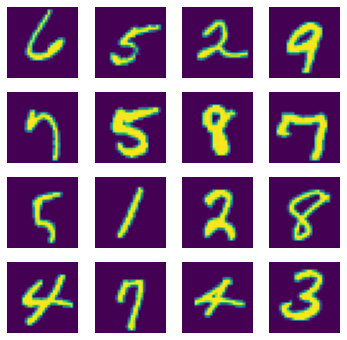

In [ ]:
fig = plt.figure(figsize=(6,6))
for i in range(16):
  index = np.random.randint(len(train_data))
  img, label = train_data[index]
  fig.add_subplot(4, 4, i+1)
#  plt.title('label: {}'.format(label))
  plt.axis('off')
  plt.imshow(torch.reshape(img, (28,28)))

###Train autoencoder

In [ ]:
model = Autoencoder().to(device)
criterion = nn.MSELoss().to(device)
optimiser = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10

In [ ]:
autoencoder, loss_history_ae = train_autoencoder(model, criterion, optimiser, train_loader, num_epochs)

epoch [1/10], loss:0.0281

epoch [2/10], loss:0.0208

epoch [3/10], loss:0.0166

epoch [4/10], loss:0.0181

epoch [5/10], loss:0.0177

epoch [6/10], loss:0.0128

epoch [7/10], loss:0.0151

epoch [8/10], loss:0.0144

epoch [9/10], loss:0.0119

epoch [10/10], loss:0.0106



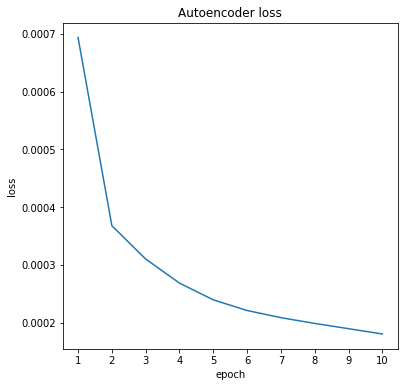

In [ ]:
plt.figure(figsize=(6,6))
plt.title('Autoencoder loss')
plt.xticks(range(1,num_epochs+1))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(range(1,num_epochs+1), loss_history_ae,);

In [ ]:
# save trained model
os.chdir("/content/drive/My Drive/Excessive-invariance")
torch.save(autoencoder.state_dict(), "autoencoder.pth")


In [25]:
# download pretrained model
autoencoder = Autoencoder()
autoencoder.load_state_dict(torch.load('autoencoder.pth'))
autoencoder.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=512, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=64, out_features=64, bias=True)
    (9): LeakyReLU(negative_slope=0.01)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=128, out_features=512, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=512, out_features=1024, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in

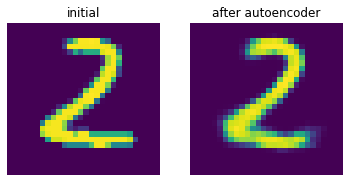

In [ ]:
fig = plt.figure(figsize=(6,3))
fig.add_subplot(1, 2, 1)
index = np.random.randint(len(val_data))
img, _ = val_data[index]
plt.title('initial')
plt.axis('off')
plt.imshow(torch.reshape(img, (28,28)));

fig.add_subplot(1, 2, 2)
img = Variable(img).to(device)
img_encoded = autoencoder(img.view(img.shape[0], -1))
img_encoded = torch.reshape(img_encoded, (28, 28))
plt.title('after autoencoder')
plt.axis('off')
plt.imshow(img_encoded.cpu().detach());

###Train classifier

In [ ]:
model = Classifier().to(device)
#model = nn.Sequential(nn.Linear(10,10), nn.ReLU(), nn.Linear(10,10)).to(device)

criterion = nn.CrossEntropyLoss().to(device)
#optimizer = optim.Adam(model.parameters(), lr=1e-3)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
num_epochs = 10

In [ ]:
classifier, loss_history, acc_history = train_classifier(model, autoencoder, criterion, optimizer, dataloaders, dataset_sizes, num_epochs)

train epoch [1/10], loss: 0.9299, acc: 0.6781
val epoch [1/10], loss: 0.7339, acc: 0.7456

train epoch [2/10], loss: 0.6648, acc: 0.7730
val epoch [2/10], loss: 0.6076, acc: 0.7956

train epoch [3/10], loss: 0.5731, acc: 0.8026
val epoch [3/10], loss: 0.5602, acc: 0.8113

train epoch [4/10], loss: 0.5272, acc: 0.8188
val epoch [4/10], loss: 0.5108, acc: 0.8332

train epoch [5/10], loss: 0.4938, acc: 0.8324
val epoch [5/10], loss: 0.4780, acc: 0.8428

train epoch [6/10], loss: 0.4677, acc: 0.8426
val epoch [6/10], loss: 0.5036, acc: 0.8363

train epoch [7/10], loss: 0.4458, acc: 0.8502
val epoch [7/10], loss: 0.4590, acc: 0.8469

train epoch [8/10], loss: 0.4298, acc: 0.8574
val epoch [8/10], loss: 0.4264, acc: 0.8607

train epoch [9/10], loss: 0.4199, acc: 0.8618
val epoch [9/10], loss: 0.4523, acc: 0.8558

train epoch [10/10], loss: 0.4116, acc: 0.8650
val epoch [10/10], loss: 0.4150, acc: 0.8624



In [ ]:
# save trained model
os.chdir("/content/drive/My Drive/Excessive-invariance")
torch.save(classifier.state_dict(), "semantic_classifier.pth")

In [ ]:
#download pretrained model
classifier = Classifier().to(device)
classifier.load_state_dict(torch.load('semantic_classifier.pth'))
classifier.eval()

Classifier(
  (classifier): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=10, bias=True)
  )
)

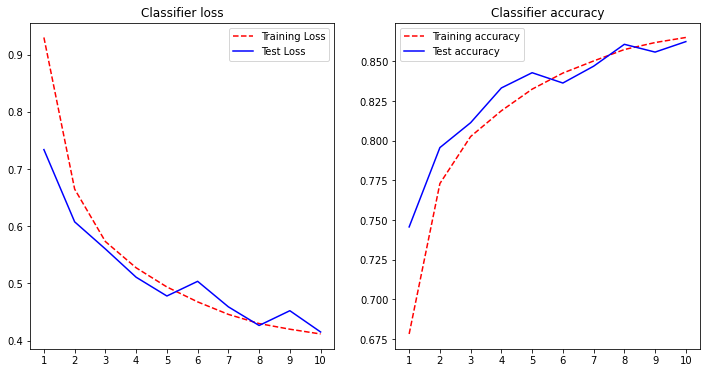

In [ ]:
fig = plt.figure(figsize=(12,6))
fig.add_subplot(1, 2, 1)
plt.title('Classifier loss')
plt.xticks(range(1,num_epochs+1))
plt.plot(range(1,num_epochs+1), loss_history['train'], 'r--')
plt.plot(range(1,num_epochs+1), loss_history['val'], 'b-')
plt.legend(['Training Loss', 'Test Loss']);

fig.add_subplot(1, 2, 2)
plt.title('Classifier accuracy')
plt.xticks(range(1,num_epochs+1))
plt.plot(range(1,num_epochs+1), acc_history['train'], 'r--')
plt.plot(range(1,num_epochs+1), acc_history['val'], 'b-')
plt.legend(['Training accuracy', 'Test accuracy']);

### Build full model with domain adaptation loss

---



In [ ]:
model = Full_model()
model.autoencoder = autoencoder

params_to_update = chain(model.semantic_classifier.parameters(),model.nuisance_classifier.parameters())

optimizer = torch.optim.Adam(params_to_update, lr=1e-2)

num_epochs = 10

In [ ]:
full_model, acc_history, loss_history, acc_nuisance_history = train_full_model(model, optimizer, nn.CrossEntropyLoss(), nn.BCEWithLogitsLoss(), dataloaders, num_epochs)

train epoch [1/10], class acc: 0.6821, loss: -106557.1094
val epoch [1/10], class acc: 0.7426, loss: -320571.2500
train epoch [2/10], class acc: 0.7727, loss: -711069.5000
val epoch [2/10], class acc: 0.7909, loss: -1184754.1250
train epoch [3/10], class acc: 0.8066, loss: -1787654.2500
val epoch [3/10], class acc: 0.8170, loss: -2465526.5000
train epoch [4/10], class acc: 0.8241, loss: -3242351.7500
val epoch [4/10], class acc: 0.8357, loss: -4095260.7500
train epoch [5/10], class acc: 0.8373, loss: -5026098.0000
val epoch [5/10], class acc: 0.8424, loss: -6040160.5000
train epoch [6/10], class acc: 0.8514, loss: -7114330.5000
val epoch [6/10], class acc: 0.8572, loss: -8282201.5000
train epoch [7/10], class acc: 0.8577, loss: -9493666.0000
val epoch [7/10], class acc: 0.8604, loss: -10812676.0000
train epoch [8/10], class acc: 0.8648, loss: -12157829.0000
val epoch [8/10], class acc: 0.8625, loss: -13625862.0000
train epoch [9/10], class acc: 0.8681, loss: -15100729.0000
val epoch [9

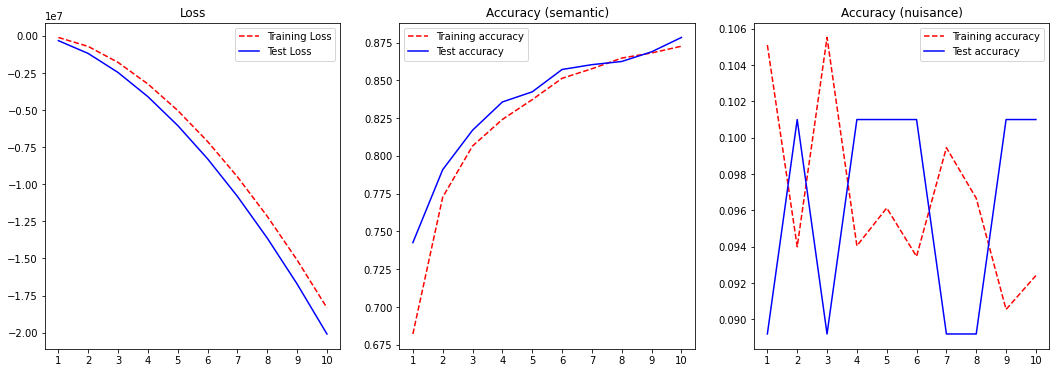

In [ ]:
fig = plt.figure(figsize=(18,6))
fig.add_subplot(1, 3, 1)
plt.title('Loss')
plt.xticks(range(1,num_epochs+1))
plt.plot(range(1,num_epochs+1), loss_history['train'], 'r--')
plt.plot(range(1,num_epochs+1), loss_history['val'], 'b-')
plt.legend(['Training Loss', 'Test Loss']);

fig.add_subplot(1, 3, 2)
plt.title('Accuracy (semantic)')
plt.xticks(range(1,num_epochs+1))
plt.plot(range(1,num_epochs+1), acc_history['train'], 'r--')
plt.plot(range(1,num_epochs+1), acc_history['val'], 'b-')
plt.legend(['Training accuracy', 'Test accuracy']);

fig.add_subplot(1, 3, 3)
plt.title('Accuracy (nuisance)')
plt.xticks(range(1,num_epochs+1))
plt.plot(range(1,num_epochs+1), acc_nuisance_history['train'], 'r--')
plt.plot(range(1,num_epochs+1), acc_nuisance_history['val'], 'b-')
plt.legend(['Training accuracy', 'Test accuracy']);


In [ ]:
# save trained model
os.chdir("/content/drive/My Drive/Excessive-invariance")
torch.save(full_model.state_dict(), "full_model.pth")

In [ ]:
#download pretrained model
full_model = Full_model().to(device)
full_model.load_state_dict(torch.load('full_model.pth'))
full_model.eval()

Full_model(
  (autoencoder): Autoencoder(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=1024, out_features=512, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=512, out_features=128, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=128, out_features=64, bias=True)
      (7): LeakyReLU(negative_slope=0.01)
      (8): Linear(in_features=64, out_features=64, bias=True)
      (9): LeakyReLU(negative_slope=0.01)
    )
    (decoder): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=64, out_features=128, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=128, out_features=512, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=512, out_features=1024, 

### Attack it

In [ ]:
def attack(encoder, classifier, full_model, input, target, num_iter, alpha, df=None):
  with torch.set_grad_enabled(True):
    input = torch.reshape(input, (1, 28*28)).to(device)
    target = torch.reshape(target, (1, 28*28)).to(device)

    first_flip = None 
    first_flip_da = None   # da = domain adaptation
    init_label = classifier.predict_by_image(input, autoencoder)
    target_label = classifier.predict_by_image(target, autoencoder)
    output_targ = encoder(target)[:, :10]
    best_loss = 10000.

    img = deepcopy(input)
    best_img = deepcopy(img)
    img = Variable(img, requires_grad=True).to(device)

    for i in range(num_iter):
      output = encoder(img)[:, :10]
      loss = torch.norm(output - output_targ, p=2)
      loss.backward(retain_graph=True)

      if loss.item() < best_loss:
        best_loss = loss.item()
        best_img = deepcopy(img)
      
      #gradien descent step
      img.data -= alpha * torch.sign(img.grad.data)

      curr_label = classifier.predict_by_image(img, autoencoder)
      curr_label_da = full_model.semantic_classifier.predict_by_image(img, autoencoder)
      
      if curr_label == target_label and first_flip is None:
        first_flip = i
      if curr_label_da == target_label and first_flip_da is None:
        first_flip_da = i
      '''
      if curr_label != init_label and first_flip is None:
        first_flip = i
      if curr_label_da != init_label and first_flip_da is None:
        first_flip_da = i
      '''

  if df is not None:
      df = df.append({'input': init_label,
                      'target': target_label,
                      'flip': first_flip,
                      'flip_da': first_flip_da},
                      ignore_index=True)

  return best_img, best_loss, df

full model prediction:  4
classifier prediction:  4


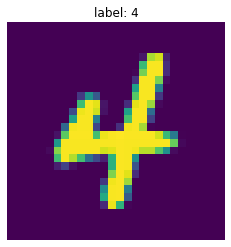

In [ ]:
index1 = np.random.randint(len(train_loader.dataset))
img1, label1 = train_loader.dataset[index1]
plt.title('label: {}'.format(label1))
plt.axis('off')
plt.imshow(torch.reshape(img1, (28,28)));

print("full model prediction: ", full_model.semantic_classifier.predict_by_image(img1, full_model.autoencoder))
print("classifier prediction: ", classifier.predict_by_image(img1, autoencoder))

full model prediction:  8
classifier prediction:  8


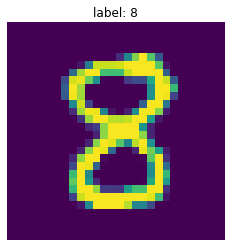

In [ ]:
index2 = np.random.randint(len(train_loader.dataset))
img2, label2 = train_loader.dataset[index2]
plt.title('label: {}'.format(label2))
plt.axis('off')
plt.imshow(torch.reshape(img2, (28,28)));

print("full model prediction: ", full_model.semantic_classifier.predict_by_image(img2, full_model.autoencoder))
print("classifier prediction: ", classifier.predict_by_image(img2, autoencoder))

In [ ]:
df = pd.DataFrame(columns=[ 'iteration','input', 'target', 'current', 'current_da'])

full model prediction:  2
classifier prediction:  8


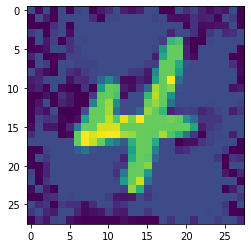

In [ ]:
adv, _, df= attack(autoencoder.encoder, classifier, full_model, img1, img2, 70, 1./255, df)

plt.imshow(torch.reshape(adv, (28, 28)).detach());
print("full model prediction: ", full_model.semantic_classifier.predict_by_image(adv, full_model.autoencoder))
print("classifier prediction: ", classifier.predict_by_image(adv, autoencoder))

In [ ]:
df = pd.DataFrame(columns=['input', 'target', 'flip', 'flip_da'])

In [ ]:
# take a lot of data

for i in range(1000):
  index = np.random.randint(len(val_loader.dataset))
  input, _ = val_loader.dataset[index]

  index = np.random.randint(len(val_loader.dataset))
  target, _ = val_loader.dataset[index]

  _, _, df= attack(autoencoder.encoder, classifier, full_model, input, target, 100, 1./255, df)


  

In [ ]:
df.to_csv('test_domain_adaptation.csv')

###Some statistics

In [5]:
# flip: current label = target label
df1 = pd.read_csv('test_domain_adaptation.csv')
df1

,Unnamed: 0,input,target,flip,flip_da
0,0,3.0,5.0,NaN,NaN
1,1,5.0,5.0,0.0,0.0
2,2,1.0,1.0,0.0,0.0
3,3,8.0,6.0,NaN,NaN
4,4,2.0,7.0,87.0,NaN
...,...,...,...,...,...
995,995,6.0,4.0,24.0,19.0
996,996,7.0,5.0,32.0,26.0
997,997,4.0,1.0,NaN,NaN
998,998,1.0,7.0,5.0,10.0


In [22]:
tmp = df1[df1['flip'].notnull()]
correct = len(tmp[tmp['flip_da'].isna()])
tmp = tmp[tmp['flip_da'].notnull()]
correct += len(tmp[tmp['flip_da'] > tmp['flip']])
wrong = len(tmp[tmp['flip_da'] <= tmp['flip']])
print('correct: {}, wrong: {}'.format(correct, wrong))

correct: 320, wrong: 275


In [23]:
# flip: current label != initial label
df2 = pd.read_csv('test_domain_adaptation2.csv')
df2

,Unnamed: 0,input,target,flip,flip_da
0,0,6.0,6.0,27.0,26.0
1,1,3.0,6.0,34.0,35.0
2,2,2.0,8.0,12.0,13.0
3,3,2.0,6.0,15.0,11.0
4,4,6.0,8.0,12.0,2.0
...,...,...,...,...,...
995,995,5.0,8.0,NaN,NaN
996,996,1.0,4.0,25.0,22.0
997,997,8.0,1.0,NaN,NaN
998,998,7.0,9.0,76.0,61.0


In [24]:
tmp = df2[df2['flip'].notnull()]
correct = len(tmp[tmp['flip_da'].isna()])
tmp = tmp[tmp['flip_da'].notnull()]
correct += len(tmp[tmp['flip_da'] > tmp['flip']])
wrong = len(tmp[tmp['flip_da'] <= tmp['flip']])
print('correct: {}, wrong: {}'.format(correct, wrong))

correct: 420, wrong: 489


### JPEG convertation

In [ ]:
def to_jpg_and_back(img):
  img = torch.reshape(img, (28, 28))
  img = img.data.cpu().numpy()

  #make jpg
  img = img * 255.0
  img = np.clip(img, 0, 255).astype(np.uint8)
  img_pil = torchvision.transforms.ToPILImage()(img)
  img_pil.save('img.jpg', 'JPEG')

  #back to tensor
  img_back = (np.asarray(Image.open('img.jpg')) / 255.0).astype(np.float32)
  transform = transforms.ToTensor()
  img_back = transform(img_back)
  img_back = torch.reshape(img_back, (1, 28, 28))
  
  return img_back

classifier prediction:  8


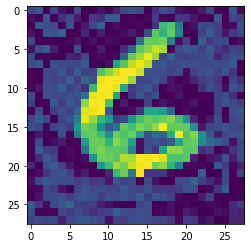

In [ ]:
adv_jpg = to_jpg_and_back(adv)
plt.imshow(adv_jpg[0])

print('classifier prediction: ', classifier.predict_by_image(adv_jpg, autoencoder))